## Adversarial Patch for Object Detection

__Description__:

This notebook demonstrates how to perform adversarial patch attacks on object detection models using HEART and MAITE. For the purposes of this demonstration, YOLO v5 we be the object detection model of choice and a variety of images from the COCO data set will be used for executing detection and attack.

__Intended Audience__:

Advanced T&E Users

## Contents:
1. Notebook imports and utility functions
2. Define the object detector
3. Prepare images and detect objects
4. Define the patch attack
5. Execute the attack
6. Conclusion
7. Next Steps

## 1. Notebook imports

In [21]:
import requests
import numpy as np
from PIL import Image
import numpy as np
from torchvision.transforms import transforms
from heart_library.estimators.object_detection import JaticPyTorchYolo
from heart_library.attacks.attack import JaticAttack

from maite.protocols import ObjectDetector, HasDetectionPredictions
from art.attacks.evasion import AdversarialPatchPyTorch

import cv2
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

coco_labels = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 
        'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 
        'teddy bear', 'hair drier', 'toothbrush']

def extract_predictions(predictions_, conf_thresh):
    # Get the predicted class
    predictions_class = [coco_labels[i] for i in list(predictions_["labels"])]
    #  print("\npredicted classes:", predictions_class)
    if len(predictions_class) < 1:
        return [], [], []
    # Get the predicted bounding boxes
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_["boxes"])]

    # Get the predicted prediction score
    predictions_score = list(predictions_["scores"])
    # print("predicted score:", predictions_score)

    # Get a list of index with score greater than threshold
    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t  # [-1] #indices where score over threshold
    else:
        # no predictions esxceeding threshold
        return [], [], []
    # predictions in score order
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores


def plot_image_with_boxes(img, boxes, pred_cls, title):
    text_size = 1
    text_th = 2
    rect_th = 1

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        # Write the prediction class
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img.astype(np.uint8), interpolation="nearest")
    
def filter_boxes(predictions, conf_thresh):
    dictionary = {}

    boxes_list = []
    scores_list = []
    labels_list = []

    for i in range(len(predictions[0]["boxes"])):
        score = predictions[0]["scores"][i]
        if score >= conf_thresh:
            boxes_list.append(predictions[0]["boxes"][i])
            scores_list.append(predictions[0]["scores"][[i]])
            labels_list.append(predictions[0]["labels"][[i]])
            
    dictionary["boxes"] = np.vstack(boxes_list)
    dictionary["scores"] = np.hstack(scores_list)
    dictionary["labels"] = np.hstack(labels_list)

    y = [dictionary]

    return y

## 2. Define the object detector
The following cell:
- initialises the object detector which supports the MAITE functionality

In [22]:
detector = JaticPyTorchYolo(device_type='cpu',
                            input_shape=(3, 640, 640),
                            clip_values=(0, 255), 
                            attack_losses=("loss_total", "loss_cls",
                                        "loss_box",
                                        "loss_obj"),
                            labels=coco_labels)

print('Assert that the detector is aligned with MAITE protocols:', isinstance(detector, ObjectDetector))

Assert that the detector is aligned with JATIC toolbox protocols: True


## 3. Prepare images and detect objects
The following cell:
- Downloads and transforms a number of images from the COCO dataset for demonstration purposes
- The YOLO v5 model requires images to be of shape 640x640 and pixel values ranging from 0-255
- Output predictions are returned when the detector is executed
- The utility functions are used to draw the detections which are above a specified threshold on the images along with their predicted label

Assert that the output is aligned with JATIC toolbox protocols: True


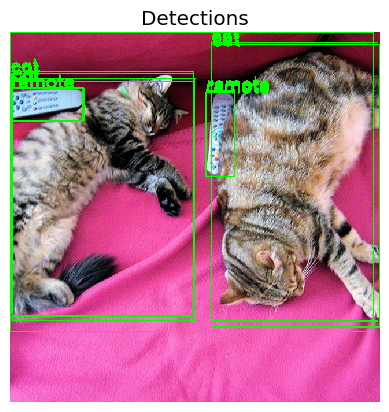

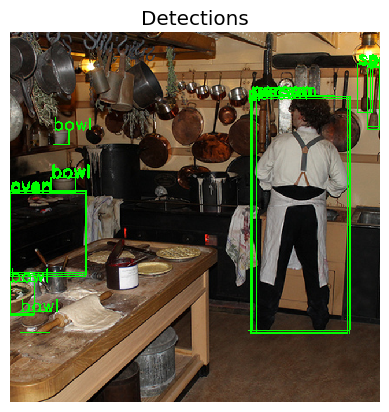

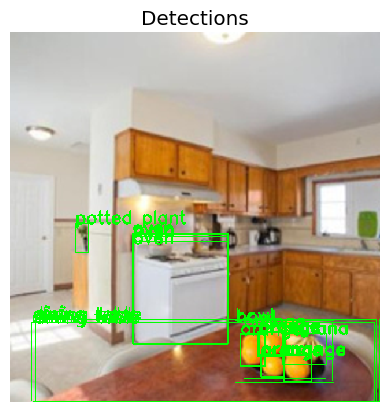

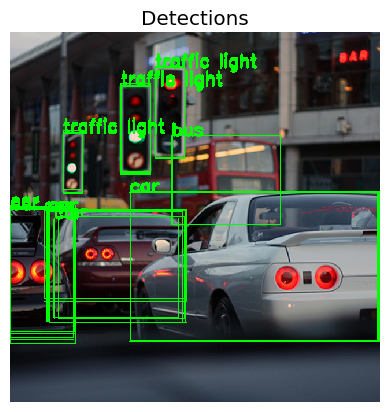

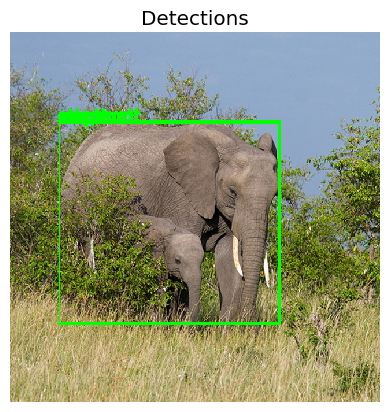

In [23]:
NUMBER_CHANNELS = 3
INPUT_SHAPE = (NUMBER_CHANNELS, 640, 640)

transform = transforms.Compose([
        transforms.Resize(INPUT_SHAPE[1], interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(INPUT_SHAPE[1]),
        transforms.ToTensor()
    ])

urls = ['http://images.cocodataset.org/val2017/000000039769.jpg',
'http://images.cocodataset.org/val2017/000000397133.jpg',
'http://images.cocodataset.org/val2017/000000037777.jpg',
'http://images.cocodataset.org/val2017/000000454661.jpg',
'http://images.cocodataset.org/val2017/000000094852.jpg']

coco_images = []
for url in urls:
    im = Image.open(requests.get(url, stream=True).raw)
    im = transform(im).numpy()
    coco_images.append(im)
coco_images = np.array(coco_images)*255

'''
Detect objects
'''
output = detector(coco_images)

print('Assert that the output is aligned with MAITE protocols:', isinstance(output, HasDetectionPredictions))


'''
View the detections
'''
for i in range(len(coco_images)):
    pred = {'boxes': output.boxes[i],
            'scores': output.scores[i],
            'labels': output.labels[i]}
    preds_orig = extract_predictions(pred, 0.3)
    plot_image_with_boxes(img=coco_images[i].transpose(1,2,0).copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

## 4. Define the patch attack
The following cell:
- defines hyperparameters for an adversarial patch attack
- wraps the patch attack in the '''JaticAttack''' so it conforms to MAITE operations

In [24]:
rotation_max=0.0
scale_min=0.5
scale_max=1.0
distortion_scale_max=0.0
learning_rate=1.99
max_iter=200
batch_size=16
patch_shape=(3, 300, 300)
patch_location=(100,100)
patch_type="circle"
optimizer="Adam"

attack = JaticAttack(
    AdversarialPatchPyTorch(detector, rotation_max=rotation_max, 
                      scale_min=scale_min, scale_max=scale_max, optimizer=optimizer, distortion_scale_max=distortion_scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size, patch_location=patch_location,
                      patch_shape=patch_shape, patch_type=patch_type, verbose=True, targeted=True)
    )

## 5. Execute the attack
The following cell:
- first creates a list of dictionaries, one for each image which contain the predicted boxes, scores and labels from the object detector
- these predictions are then filtered, to include only the detections which have a score higher than a threshold (40% confidence is selected here)
- a data dictionary is created with keys:
    - 'image': which contains all the images except the last (the image of elephants)
    - 'label': which contains the predicted (and filtered) detections for only the last image (of elephants), repeated for every image we have in added
- this is because we have defined a targeted attack and want the patch to detect 'elephants' no matter what image we are passing

In [25]:
dets = [{'boxes': output.boxes[i],
            'scores': output.scores[i],
            'labels': output.labels[i]} for i in range(len(coco_images))]

y = [filter_boxes([t], 0.8)[0] for t in dets]
data = {'image': coco_images[[0]], 'label': y[-1:]}
output = attack.run_attack(data=data)

Adversarial Patch PyTorch:   0%|          | 0/200 [00:00<?, ?it/s]

## 6. Conclusion
The following cell:
- draws the predicted detections from the adversarial images
- note that elephants now appear as detected objects in the images with the patch applied indicating a successful targeted attack

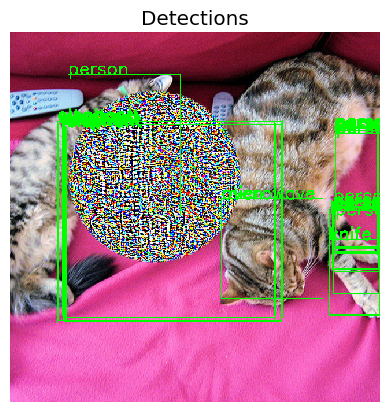

In [26]:
adv_output = detector(output.adversarial_examples)
for i in range(len(output.adversarial_examples)):
    pred = {'boxes': adv_output.boxes[i],
            'scores': adv_output.scores[i],
            'labels': adv_output.labels[i]}
    preds_orig = extract_predictions(pred, 0.2)
    plot_image_with_boxes(img=output.adversarial_examples[i].transpose(1,2,0).copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

## 7. Next Steps
- Swap in your own dataset and apply a patch attack to identify vulnerabilities
- Experiment with the hyperparameters of the adversarial attack
    - try changing attributes of the patch size, shape and location
    - what happens when a patch overlaps with an object or is further removed?
    - is the patch easily identifiable in the image?